In [ ]:
import sys
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn import datasets
    from sklearn.decomposition import PCA
except Exception as e:
    print('Some packages missing, installing...')
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "numpy", "pandas", "matplotlib", "scikit-learn"])
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn import datasets
    from sklearn.decomposition import PCA
%matplotlib inline


In [ ]:

data = datasets.fetch_california_housing(as_frame=True)
X = data.data
y = data.target
target_name = 'house_value'
print('Features shape:', X.shape)
print('Target shape:', y.shape)
display(X.head())


4.526
Features shape: (20640, 8)
Target shape: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Preprocessing: scaling, train/test split, and adding intercept column

In [ ]:

# Train/test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Standardize features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add intercept (column of ones) for analytical solutions
def add_intercept(X_arr):
    return np.hstack([np.ones((X_arr.shape[0], 1)), X_arr])

X_train_inter = add_intercept(X_train_scaled)
X_test_inter = add_intercept(X_test_scaled)

print('After scaling and adding intercept:')
print('X_train_inter shape:', X_train_inter.shape)


After scaling and adding intercept:
X_train_inter shape: (16512, 9)


## 2) Ordinary Least Squares (Normal Equation)

We compute \(\hat{\beta} = (X^T X)^{-1} X^T y\). This can fail when X^T X is singular or ill-conditioned.

OLS MSE: 0.5558915986952441 R2: 0.575787706032451


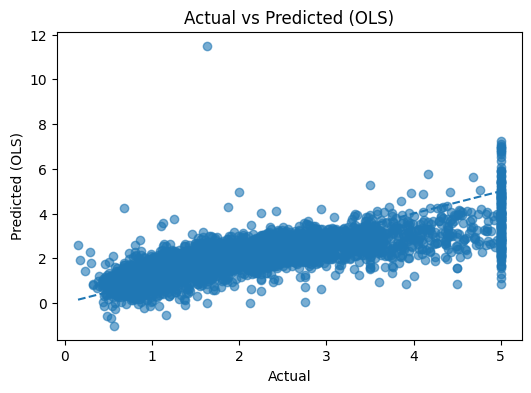

In [ ]:

def ols_normal_equation(X, y, tol=1e-12):
    # X assumed to have intercept if needed
    XtX = X.T @ X
    cond = np.linalg.cond(XtX)
    if cond > 1e12:
        print('Warning: XtX is ill-conditioned, cond:', cond)
    try:
        beta = np.linalg.inv(XtX) @ X.T @ y
    except np.linalg.LinAlgError:
        print('XtX singular — falling back to pseudo-inverse')
        beta = np.linalg.pinv(XtX) @ X.T @ y
    return beta

beta_ols = ols_normal_equation(X_train_inter, y_train.values if hasattr(y_train,'values') else y_train)
y_pred_ols = X_test_inter @ beta_ols
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)
print('OLS MSE:', mse_ols, 'R2:', r2_ols)

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_ols, alpha=0.6)
plt.xlabel('Actual')
plt.ylabel('Predicted (OLS)')
plt.title('Actual vs Predicted (OLS)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.show()


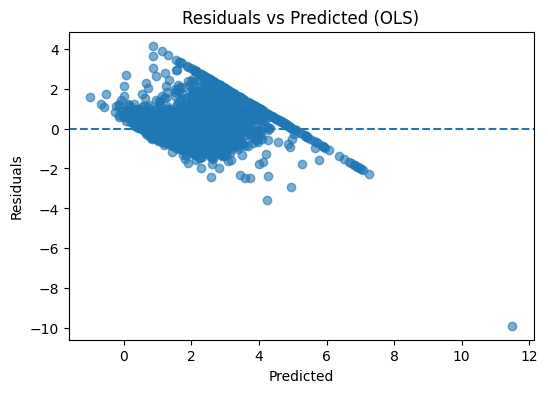

In [ ]:

# Residual plot
residuals = y_test - y_pred_ols
plt.figure(figsize=(6,4))
plt.scatter(y_pred_ols, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (OLS)')
plt.show()


## 3) SVD-based solution (pseudoinverse)

Compute SVD of X and use pseudoinverse to compute \(\hat{\beta} = V \Sigma^+ U^T y\).

SVD MSE: 0.5558915986952437 R2: 0.5757877060324512


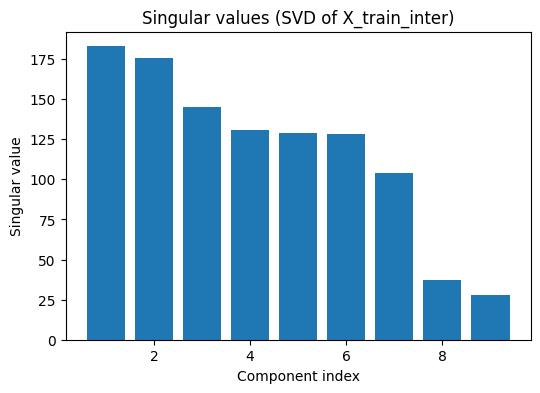

In [ ]:

def svd_pseudoinverse_solution(X, y, rcond=1e-12):
    U, s, VT = np.linalg.svd(X, full_matrices=False)
    s_inv = np.array([1/si if si > rcond else 0.0 for si in s])
    Sigma_pinv = np.diag(s_inv)
    X_pinv = VT.T @ Sigma_pinv @ U.T
    beta = X_pinv @ y
    return beta, s

beta_svd, singular_values = svd_pseudoinverse_solution(X_train_inter, y_train.values if hasattr(y_train,'values') else y_train)
y_pred_svd = X_test_inter @ beta_svd
mse_svd = mean_squared_error(y_test, y_pred_svd)
r2_svd = r2_score(y_test, y_pred_svd)
print('SVD MSE:', mse_svd, 'R2:', r2_svd)

plt.figure(figsize=(6,4))
plt.bar(range(1, len(singular_values)+1), singular_values)
plt.xlabel('Component index')
plt.ylabel('Singular value')
plt.title('Singular values (SVD of X_train_inter)')
plt.show()


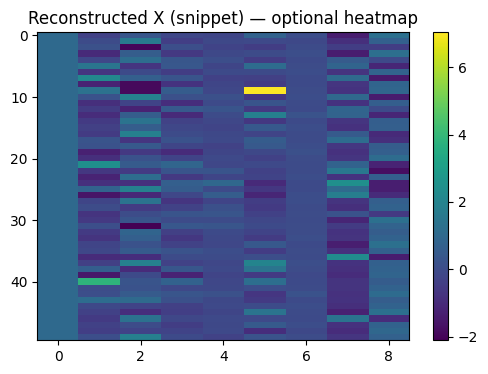

In [ ]:
try:
    U, svals, VT = np.linalg.svd(X_train_inter, full_matrices=False)
    X_recon = (U @ np.diag(svals) @ VT)
    plt.figure(figsize=(6,4))
    plt.imshow(X_recon[:50,:50], aspect='auto')
    plt.colorbar()
    plt.title('Reconstructed X')
    plt.show()
except Exception as e:
    print('Skipping heatmap (dataset may be too wide).', e)


## 4) Gradient Descent

Implement batch gradient descent to minimize MSE. We also include simple Adam implementation for comparison.

Batch GD MSE: 0.5557850992810364 R2: 0.5758689779223541
Adam MSE: 0.555891598695244 R2: 0.5757877060324511


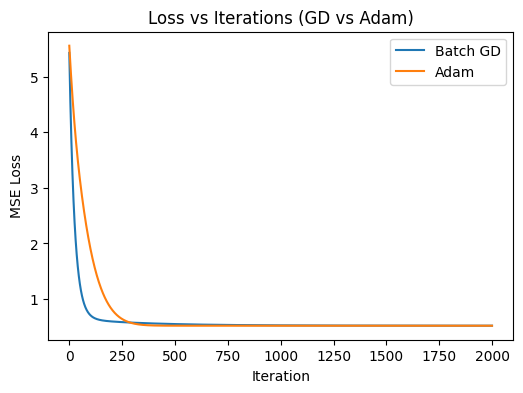

In [ ]:

def compute_mse_loss(X, y, beta):
    preds = X @ beta
    return np.mean((preds - y)**2)

def grad_mse(X, y, beta):
    n = X.shape[0]
    return (2/n) * X.T @ (X @ beta - y)

def batch_gradient_descent(X, y, lr=0.01, n_iters=1000, tol=1e-8, verbose=False):
    beta = np.zeros(X.shape[1])
    history = []
    for i in range(n_iters):
        g = grad_mse(X, y, beta)
        beta = beta - lr * g
        loss = compute_mse_loss(X, y, beta)
        history.append(loss)
        if verbose and i % (n_iters//10 + 1) == 0:
            print(f'Iter {i}, loss {loss}')
        if np.linalg.norm(g) < tol:
            if verbose: print('Converged at iteration', i)
            break
    return beta, np.array(history)

def adam_optimizer(X, y, lr=0.01, n_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8):
    w = np.zeros(X.shape[1])
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    history = []
    for t in range(1, n_iters+1):
        g = grad_mse(X, y, w)
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        w = w - lr * m_hat / (np.sqrt(v_hat) + eps)
        loss = compute_mse_loss(X, y, w)
        history.append(loss)
    return w, np.array(history)

Xg = X_train_inter.copy()
yg = y_train.values if hasattr(y_train,'values') else y_train

beta_gd, hist_gd = batch_gradient_descent(Xg, yg, lr=0.01, n_iters=2000, verbose=False)
y_pred_gd = X_test_inter @ beta_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print('Batch GD MSE:', mse_gd, 'R2:', r2_gd)

beta_adam, hist_adam = adam_optimizer(Xg, yg, lr=0.01, n_iters=2000)
y_pred_adam = X_test_inter @ beta_adam
mse_adam = mean_squared_error(y_test, y_pred_adam)
r2_adam = r2_score(y_test, y_pred_adam)
print('Adam MSE:', mse_adam, 'R2:', r2_adam)

plt.figure(figsize=(6,4))
plt.plot(hist_gd, label='Batch GD')
plt.plot(hist_adam, label='Adam')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Loss vs Iterations (GD vs Adam)')
plt.legend()
plt.show()


## 5) PCA via SVD and dimensionality reduction

Compute principal components with SVD and project data onto top-k components. Plot explained variance (scree) and error vs k.

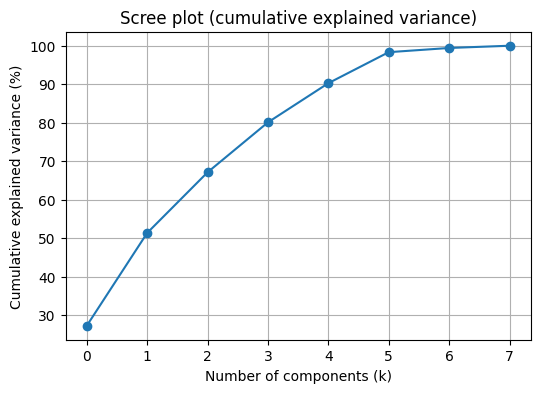

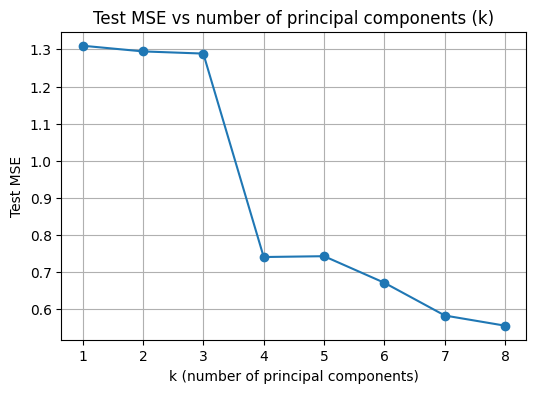

In [ ]:

# Compute SVD of centered (already standardized) X (without intercept)
X_all = np.vstack([X_train_scaled, X_test_scaled])
U, s_vals, VT = np.linalg.svd(X_all - X_all.mean(axis=0), full_matrices=False)
explained_var_ratio = (s_vals**2) / np.sum(s_vals**2)

# Scree plot (cumulative)
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(explained_var_ratio)*100, marker='o')
plt.xlabel('Number of components (k)')
plt.ylabel('Cumulative explained variance (%)')
plt.title('Scree plot (cumulative explained variance)')
plt.grid(True)
plt.show()

# Evaluate regression error vs k
max_k = min(X_train_scaled.shape[1], 20)
mse_vs_k = []
ks = list(range(1, max_k+1))
for k in ks:
    pca = PCA(n_components=k)
    Xp_train = pca.fit_transform(X_train_scaled)
    Xp_test = pca.transform(X_test_scaled)
    Xp_train_i = add_intercept(Xp_train)
    Xp_test_i = add_intercept(Xp_test)
    beta_k = ols_normal_equation(Xp_train_i, y_train.values if hasattr(y_train,'values') else y_train)
    ypk = Xp_test_i @ beta_k
    mse_vs_k.append(mean_squared_error(y_test, ypk))

plt.figure(figsize=(6,4))
plt.plot(ks, mse_vs_k, marker='o')
plt.xlabel('k (number of principal components)')
plt.ylabel('Test MSE')
plt.title('Test MSE vs number of principal components (k)')
plt.grid(True)
plt.show()


## 6) Compare methods: table of MSE and R2

In [ ]:

import pandas as pd
results = pd.DataFrame({
    'method': ['OLS (normal eq)', 'SVD (pseudoinverse)', 'Batch GD', 'Adam'],
    'mse': [mse_ols, mse_svd, mse_gd, mse_adam],
    'r2': [r2_ols, r2_svd, r2_gd, r2_adam]
})
display(results.style.format({'mse':'{:.4f}','r2':'{:.4f}'}))


,method,mse,r2
0,OLS (normal eq),0.5559,0.5758
1,SVD (pseudoinverse),0.5559,0.5758
2,Batch GD,0.5558,0.5759
3,Adam,0.5559,0.5758
